# ML MINI Project 1

The task is to train at least two di erent machine learning algorithms to predict the energy
consumption of the ship in terms of fuel consumption rate.  
You will have to:  
1- Perform data preprocessing  
a. What features do you use for your models and why? What is the window interval
you choose to predict the target variable?  
b. How do you prepare the data to be used in your models?  
c. Feature Engineering
2- Train the models with at least 85% accuracy.  
3- Visualize the performance of your models.  
4- Compare the results of different models, why is there a difference?  
You must submit your Python code in a Jupyter notebook along with a written report. Write a
scientific report that includes, but is not limited to, the following points: - Introduction (what is the problem you are solving, why do you think it is relevant?)  - Data Processing (What are the data processing decisions you made and how did you
implement them?)  - Modeling (What algorithms did you choose and why? How did you run them? How did you
improve the performance of your models? Were you able to achieve the required accuracy
in the first round of training?)  - Conclusion (What were the "scientific" bottlenecks? How did you overcome them? Which
algorithm was better? Possible improvements? etc...)
Note: Please understand that the submitted report should include both text and figure
explanations to cover the solution of the task. Only textual or graphical reports will not
receive points. Also, the solution notebook should be completely independent of any local
libraries or local installations in order to be reproducible by the peer reviewer.

# Mount Drive

In [ ]:
# prompt: mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Reading CSV files

In [ ]:
#read all csv files as data frames
basePath = "/content/drive/MyDrive/Colab Notebooks/ML_mini_project_1_raw_data"

csv_files = [f for f in os.listdir(basePath) if f.endswith('.csv')]
df_list = []
col_names_list = []
for file in csv_files:
  file_path = os.path.join(basePath, file)
  col_name = file.split(".")[0]
  df = pd.read_csv(file_path, names=["timestamp", col_name])
  #Converting timestamp
  df['timestamp'] = pd.to_datetime(df['timestamp'], origin='unix', unit='ns')
  df.set_index('timestamp', inplace=True)
  #Appendning to list
  df_list.append(df)
  col_names_list.append(col_name)

  # #find duration of sampleset based on time stamp
  # time_duration = df.index[-1] - df.index[0]
  # print(f"Duration for {col_name}: {time_duration}")
print(f'\n {len(df_list)}')





 20


# Data Processing (Resampling and interpolation)

In [ ]:
df_resampled_list = []
for i,df in enumerate(df_list):
  col_name = col_names_list[i]
  # print("\n Data of ------------------------------------------------------------" + col_name)

  if pd.api.types.is_object_dtype(df[col_name].dtype):
      df[col_name] = df[col_name].str.rstrip('NSEW').astype(float)
  else:
      df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

  # 1 sec interval for sampling
  interval_seconds = 1
  resampled_df = df.resample(f'{interval_seconds}s').mean()

  # Interpolate the missing values
  interpolated_df = resampled_df.interpolate(method='linear')

  # print("Head after interpolation:")
  # print(interpolated_df.head())
  # print("\n Duplicate sum :" + str(interpolated_df.index.duplicated().sum()))

  df_resampled_list.append(interpolated_df)


# Data Processing (Merging)

In [ ]:
#Merging data frames to single data frame
merged_df = df_resampled_list[0]
for i, df in enumerate(df_resampled_list[1:]):
  # print(f"{i}) merging "+ col_names_list[i+1])
  merged_df = pd.merge(merged_df, df, on='timestamp')

In [ ]:
merged_df.head()
merged_df.shape
#print null or na values
# print(merged_df.isnull().sum())

(47938, 20)

# Correlation Matrix & Heatmap

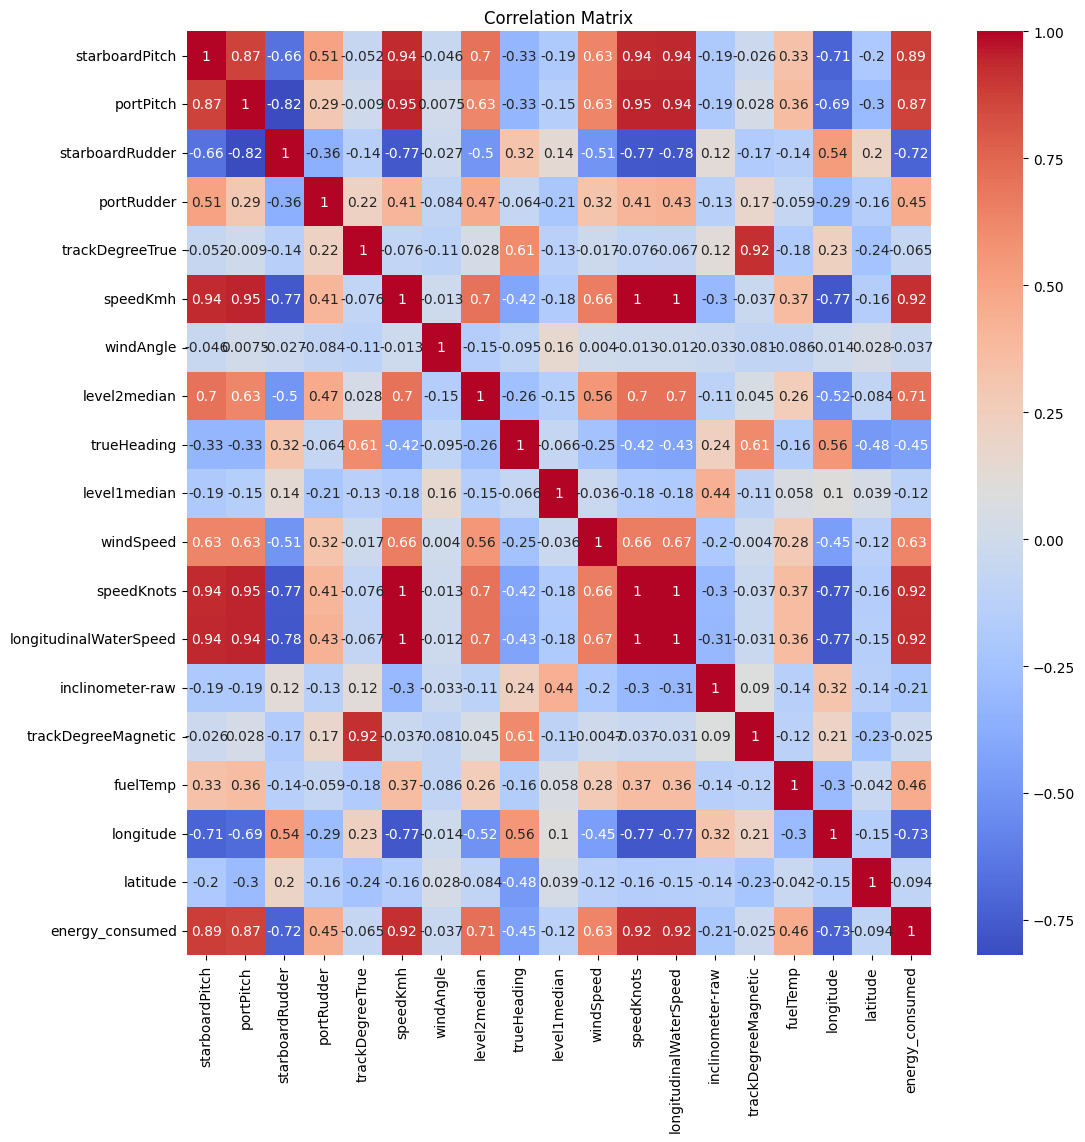

In [ ]:
merged_df['energy_consumed'] = (merged_df['fuelDensity'] * merged_df['fuelVolumeFlowRate'] * 3600) / 1000

#remove features used for energy consumption
corr_df = merged_df.drop(columns=['fuelDensity', 'fuelVolumeFlowRate'], inplace=False)

#plot correlation matrix with energy consumed
corr_matrix = corr_df.corr()

# plot
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection

In [ ]:
#threshold
direct_threshold_lower = 0.5
direct_threshold_upper = 0.9
inverse_threshold = -0.4

direct_correlated_features = []
inverse_correlated_features = []

target_corr = corr_matrix['energy_consumed']

#direct correlated features in descending order
direct_correlated_features = target_corr[(target_corr > direct_threshold_lower) & (target_corr < direct_threshold_upper) ].sort_values(ascending=False)

#inverse correlated features in descedningorder
inverse_correlated_features = target_corr[target_corr < inverse_threshold].sort_values(ascending=True)

print("Direct correlated features:")
print(direct_correlated_features)

print("\nInverse correlated features:")
print(inverse_correlated_features)

Direct correlated features:
starboardPitch    0.885949
portPitch         0.869581
level2median      0.709158
windSpeed         0.631640
Name: energy_consumed, dtype: float64

Inverse correlated features:
longitude         -0.731827
starboardRudder   -0.718098
trueHeading       -0.445424
Name: energy_consumed, dtype: float64


In [ ]:
#Selected features
features_set = [
    "windSpeed",
    "portPitch",
    "starboardRudder",
    "trueHeading"
]

## Selected Features Scatter Plot

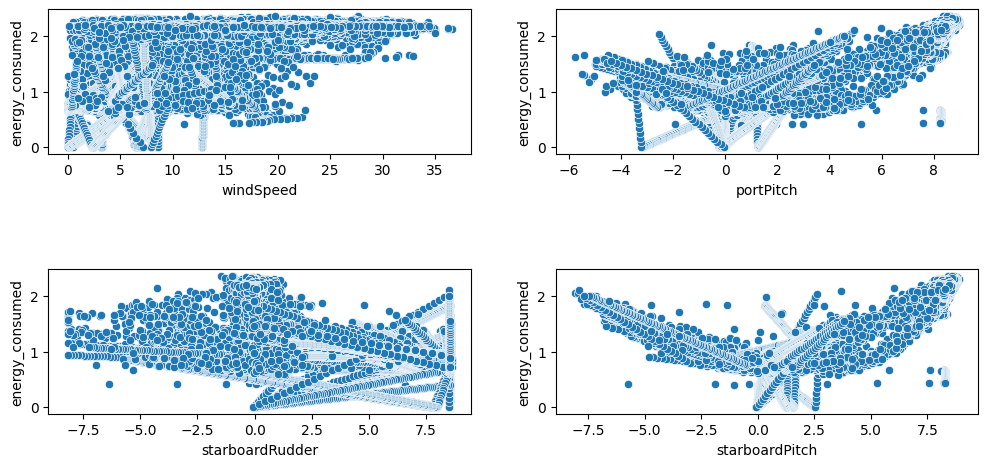

In [ ]:
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features_set):
    plt.subplot(4, 2, i + 1)
    plt.subplots_adjust(hspace=0.8)
    sns.scatterplot(data=merged_df, x=feature, y='energy_consumed')

# Random Forest

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# train test split
X = merged_df[features_set]
y = merged_df['energy_consumed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.00533649481215671
R-squared: 0.9832810920208124


## Visualisation

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

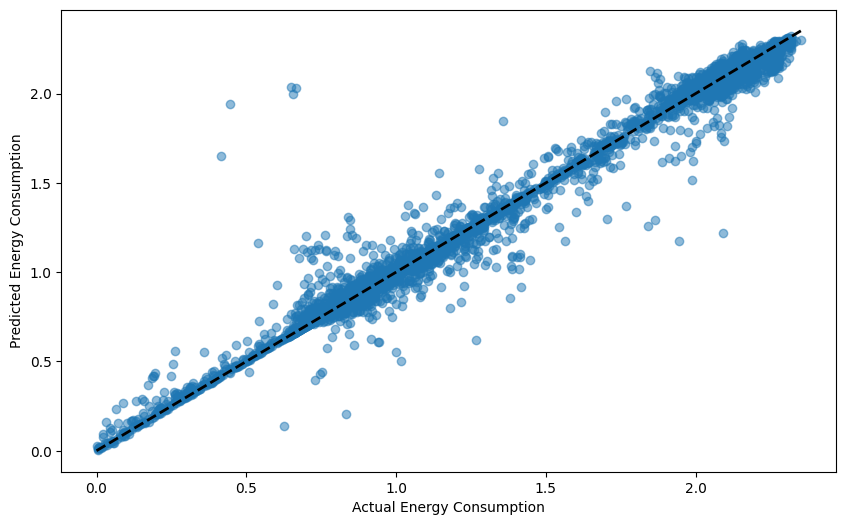

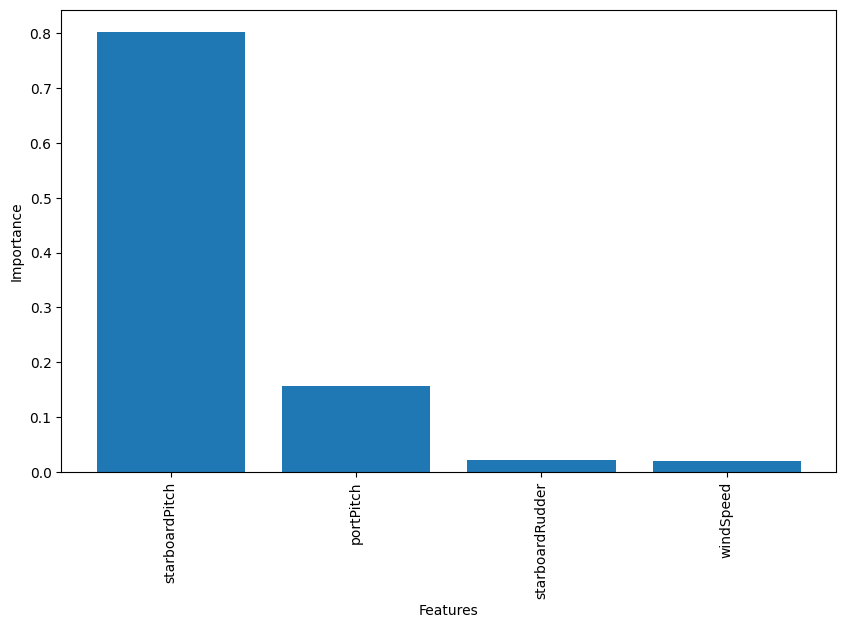

In [ ]:
#Visualisation
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')

#Feature importance ranking
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt

# Decision Tree

In [ ]:
# Decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Train test split
X = merged_df[features_set]
y = merged_df['energy_consumed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Train
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



Mean Squared Error: 0.006784787015388246
R-squared: 0.9787436821806224


## Visualisation

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

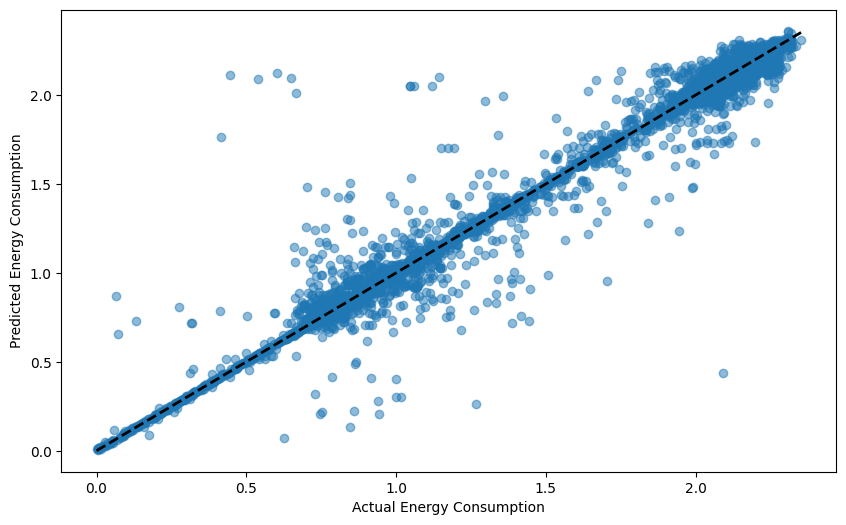

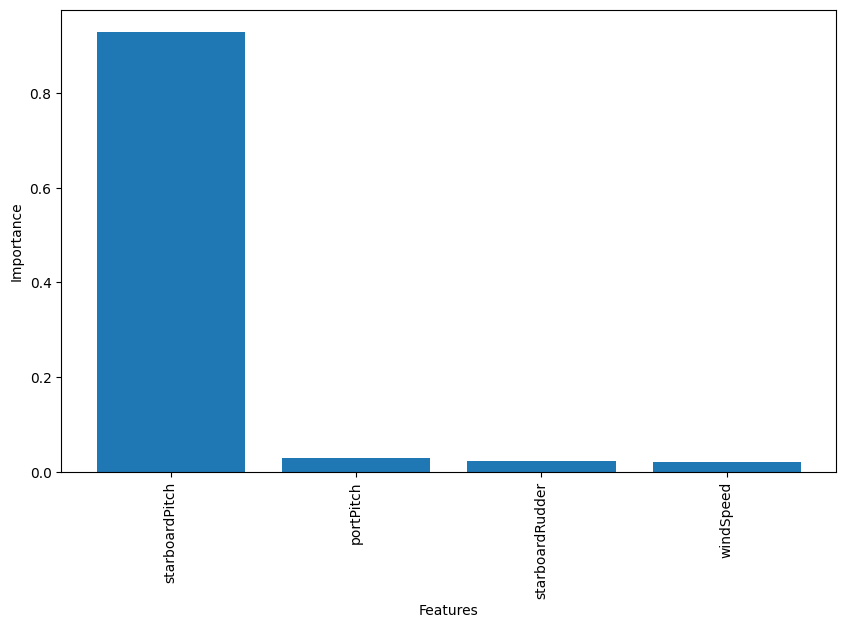

In [ ]:
#Visualise
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')

#ranked feature importance
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt

# XG Boost

In [ ]:
#XG Boost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


# Train test split
X = merged_df[features_set]
y = merged_df['energy_consumed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.0060825634900967115
R-squared: 0.9809437050258474


## Visualise

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

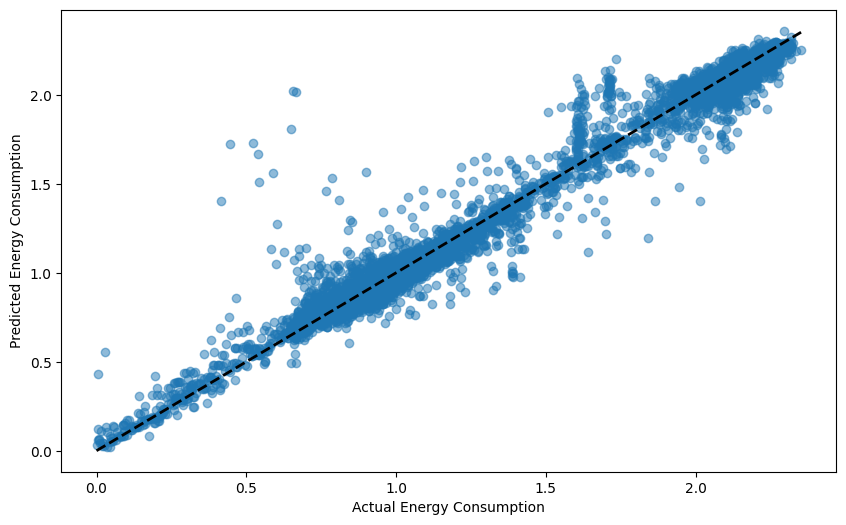

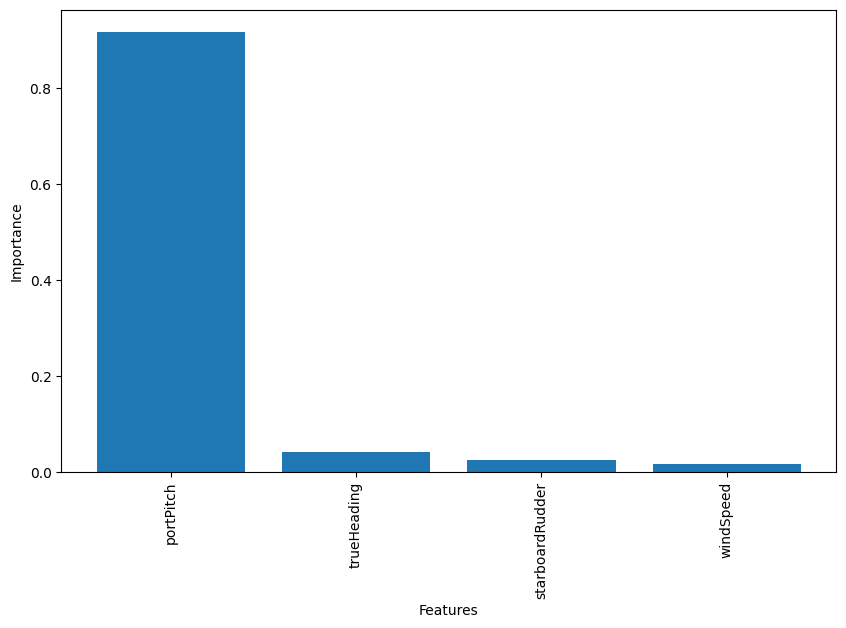

In [ ]:
#Visualise
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')

#ranked feature importance
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt
